In [2]:
import dask
dask.config.set(scheduler='multiprocessing')
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=1, threads_per_worker=4, memory_limit = '4GB')
# explicitly connect to the cluster just created
client = Client(cluster)
# Viewing the client and the cluster
client

C:\Users\Lenovo\anaconda3\lib\site-packages\distributed\node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 4617 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:4617/status,
Dashboard: http://127.0.0.1:4617/status,Workers: 1
Total threads: 4,Total memory: 3.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:4618,Workers: 1
Dashboard: http://127.0.0.1:4617/status,Total threads: 4
Started: Just now,Total memory: 3.73 GiB
Comm: tcp://127.0.0.1:4630,Total threads: 4
Dashboard: http://127.0.0.1:4631/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:4621,


In [3]:
# Importing required  libraries 
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
import dask
import dask.dataframe as dd
import math
import pandas as pd
import time

spark=SparkSession.builder\
.master("local[*]")\
.appName("WordCount")\
.getOrCreate()
sc=spark.sparkContext

In [4]:
# Loading dataset with dask
df_dask = dd.read_csv("F:/Documents\MSc Data Science & Analytics/Distributed Data Analysis/Coding/Pollution Dataset.csv", 
                 dtype={
                     'No': 'float64',
                     'year': 'float64',
                     'month': 'float64',
                     'day': 'float64',
                     'hour': 'float64',
                     'PM10': 'float64',
                     'NO2': 'float64',
                     'SO2': 'float64',
                     'CO': 'float64',
                     'O3': 'float64',
                     'RAIN': 'float64'
                     })

df_dask.head()

,Unnamed: 0,No,year,month,day,hour,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,1.0,2013.0,3.0,1.0,0.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2.0,2013.0,3.0,1.0,1.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,3.0,2013.0,3.0,1.0,2.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,4.0,2013.0,3.0,1.0,3.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,5.0,2013.0,3.0,1.0,4.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [5]:
# Loading dataset with Pandas
df_py = pd.read_csv("F:/Documents\MSc Data Science & Analytics/Distributed Data Analysis/Coding/Pollution Dataset.csv")
df_dask.head()

,Unnamed: 0,No,year,month,day,hour,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,1.0,2013.0,3.0,1.0,0.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2.0,2013.0,3.0,1.0,1.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,3.0,2013.0,3.0,1.0,2.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,4.0,2013.0,3.0,1.0,3.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,5.0,2013.0,3.0,1.0,4.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [6]:
# Checking the number of missing values 
df_dask.isna().sum().compute()

Unnamed: 0        0
No                0
year              0
month             0
day               0
hour              0
PM10           6449
SO2            9021
NO2           12116
CO            20701
O3            13277
TEMP            398
PRES            393
DEWP            403
RAIN            390
wd             1822
WSPM            318
station           0
dtype: int64

In [7]:
# Defining a function to replace outliers with missing values by using pd.DataFrame.mask
def replacing_outliers(pollution):

    pollution["PM10"] = pollution.PM10.mask(pollution.PM10 > 300)
    pollution["SO2"] = pollution.SO2.mask(pollution.SO2 > 150)
    pollution["NO2"] = pollution.NO2.mask(pollution.NO2 > 130)
    pollution["CO"] = pollution.CO.mask(pollution.CO > 3500)
    pollution["O3"] = pollution.O3.mask(pollution.O3 > 300)
    return pollution

# Applying the defined function over dask data frame to convert outliers to missing values. 
df_dask = replacing_outliers(df_dask)

# The number of missing values should have been increased as the outliers are converted to missing values. 
df_dask.isna().sum().compute()

Unnamed: 0        0
No                0
year              0
month             0
day               0
hour              0
PM10          22498
SO2            9844
NO2           24076
CO            40050
O3            13882
TEMP            398
PRES            393
DEWP            403
RAIN            390
wd             1822
WSPM            318
station           0
dtype: int64

In [8]:
# Grouping the dataset by station and monnth and aggregating by mean value for the numerical values. 
grouped_mean = df_dask.groupby(['station', 'month']).agg({'TEMP': ['mean'], 'PM10': ['mean'] ,'NO2': ['mean'] , 'SO2': ['mean'], 'O3': ['mean'], 'CO': ['mean'], 'PRES': ['mean'], 'DEWP' : ['mean'], 'RAIN' : ['mean'], 'WSPM' : ['mean']}).compute()

# All the numerical arrays that contain missing values and need imputation
cols = ['TEMP', 'PM10', 'NO2' , 'SO2', 'O3', 'CO', 'PRES', 'DEWP', 'RAIN', 'WSPM']

grouped_mean

TEMP        PM10        NO2        SO2         O3  \
                          mean        mean       mean       mean       mean   
station       month                                                           
Aotizhongxin  1.0    -1.636747   94.986605  59.601173  33.743594  27.034153   
              2.0     1.299797   83.311423  49.748823  29.248092  43.634351   
              3.0     8.403951  123.758495  59.476882  31.170496  47.584506   
              4.0    15.309271  122.492878  51.297881  16.405318  65.563523   
              5.0    21.419657  106.944808  47.386600  16.004978  88.536497   
...                        ...         ...        ...        ...        ...   
Wanshouxigong 8.0    26.941364   76.018093  42.457173   4.199956  88.640797   
              9.0    21.099595   86.999044  52.071401   6.759432  54.722151   
              10.0   13.725791  103.529200  61.980840   7.890503  28.113848   
              11.0    4.878368  107.448871  60.934050  15.670112  18.267377   
              12.0    0.011559  101.316262  63.495453  29.419682  18.779230   

                              CO         PRES       DEWP      RAIN      WSPM  
                            mean         mean       mean      mean      mean  
station       month                                                           
Aotizhongxin  1.0    1375.445705  1023.247352 -14.333536  0.000337  1.878571  
              2.0    1136.389922  1021.382380 -12.689856  0.010845  1.974142  
              3.0    1233.903132  1014.972116  -7.177352  0.009073  2.028125  
              4.0     850.421206  1009.360347   1.170903  0.023542  2.173958  
              5.0     785.214286  1003.427655   7.710517  0.047413  2.043548  
...                          ...          ...        ...       ...       ...  
Wanshouxigong 8.0     984.581197  1001.785450  18.989012  0.106788  1.511526  
              9.0    1071.262153  1009.226871  14.037626  0.116986  1.405322  
              10.0   1230.693069  1015.436814   5.753360  0.042977  1.470027  
              11.0   1432.402235  1020.464757  -4.338507  0.015208  1.603333  
              12.0   1398.229264  1023.147614 -11.490860  0.000706  1.795262  

[144 rows x 10 columns]

In [9]:
# Defining a function that takes the station, month and column name, to return the mean.
def getmean(station, month, col):
    # using the station and month values from the grouped table, we extract the mean
    mean = grouped_mean.loc[(station, month)][col]['mean']
    return mean

In [10]:
# Defining a function that imputes the missing data with the mean value of the variable in the same month and station. 
def clean_data(): 
    # first iterate thro column names, and make nested loops for the values inside each column.
    for col in cols:
        for x, c in df_py[col].iteritems():
            # check if value is null / NA 
            if pd.isnull(c):
                # if it is null then get station and month
                station = df_py.loc[x, 'station']
                month = df_py.loc[x, 'month']
                # call the function getmean() to get the mean from the grouped table.
                mean = getmean(station, month, col)
                # change value from Null to mean.
                df_py.loc[x, col] = mean

In [11]:
#custom function to impute values for NAs in the column list by using the custom getmean function
def clean_data(poll): 
    # first iterate through column names, and make nested loops for the values inside each column
    for col in cols:
        # x is index, c is the value in that location
        for x, c in poll[col].iteritems():
            # check if value is null / NA 
            if pd.isnull(c):
                # if it is null then get station and month
                station = poll.loc[x, 'station']
                month = poll.loc[x, 'month']
                # call the function getmean() to get the mean from the grouped table.
                mean = getmean(station, month, col)
                # change value from Null to mean.
                poll.loc[x, col] = mean
    return poll

In [12]:
#creating a grouped dataframe of wind direction's mode values for each station and month
grouped_mode = df_py.groupby(['station', 'month'])['wd'].agg(pd.Series.mode)
grouped_mode

station        month
Aotizhongxin   1         NE
               2         NE
               3         NE
               4         SW
               5         SW
                       ... 
Wanshouxigong  8         SW
               9         NE
               10        NE
               11       WNW
               12       WNW
Name: wd, Length: 144, dtype: object

In [13]:
#custom function to return wind direction mode value from the grouped dataframe based on station and month
def getmode(station, month):
    mode = grouped_mode.loc[(station, month)]
    return mode

In [14]:
#custom function to impute values for NAs in the wind direction column by using the custom getmode function
def clean_wd(poll):
    # x is index, and c is the value in that location, loop through the column wd
    for x, c, in df_py['wd'].iteritems():
        # check if value is null
        if pd.isnull(c):
            #get station and month if the value is null
            station = df_py.loc[x, 'station']
            month = df_py.loc[x, 'month']
            # call get mode function
            mode = getmode(station, month)
            # replace NA with mode.
            df_py.loc[x, 'wd'] = mode
    return poll

In [15]:
#creating a dask dataframe from the pandas dataframe to store the final cleaned dataset
cleaned_pollution = dd.from_pandas(df_py, npartitions=12)
cleaned_pollution

,Unnamed: 0,No,year,month,day,hour,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
npartitions=12,,,,,,,,,,,,,,,,,,
0,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,object
35064,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385704,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420767,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [16]:
#calling the clean_data function on the final dask dataframe using parallel processing for each partition
cleaned_pollution = cleaned_pollution.map_partitions(clean_data, meta=cleaned_pollution)
cleaned_pollution.compute()

,Unnamed: 0,No,year,month,day,hour,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,1,2013,3,1,0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2,2013,3,1,1,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,3,2013,3,1,2,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,4,2013,3,1,3,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,5,2013,3,1,4,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,420764,420764,2017,2,28,19,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,0.0,NW,2.4,Wanshouxigong
420764,420765,420765,2017,2,28,20,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Wanshouxigong
420765,420766,420766,2017,2,28,21,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,NW,1.1,Wanshouxigong
420766,420767,420767,2017,2,28,22,23.0,4.0,30.0,400.0,59.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Wanshouxigong


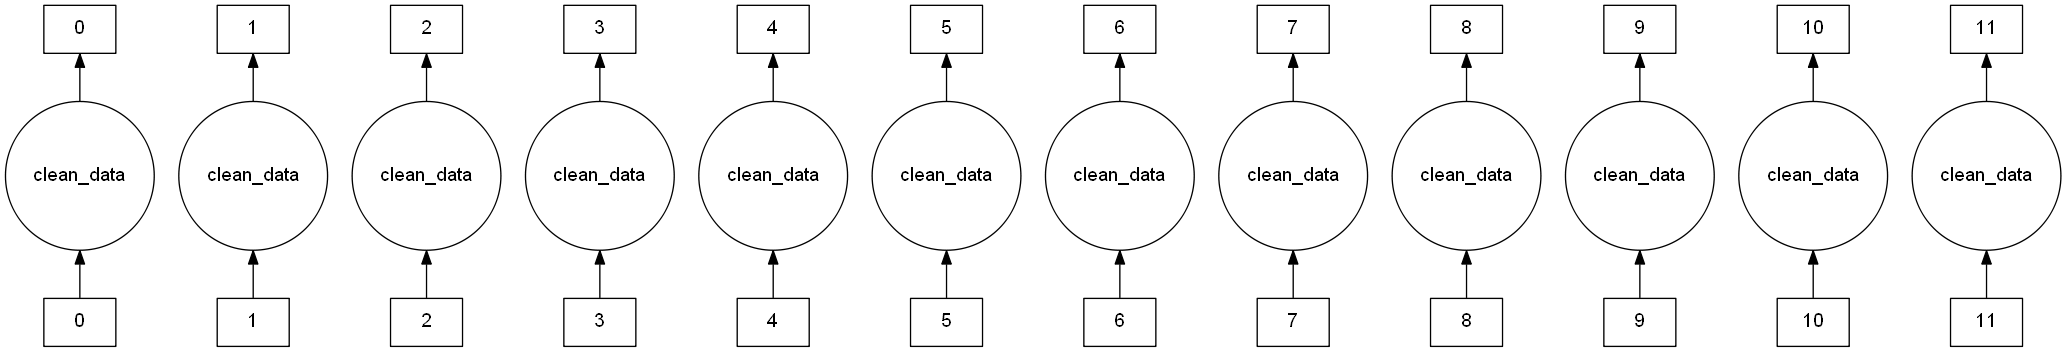

In [17]:
#visualizing how the clean_data function was executed using parallel processing for each partition of the dask dataframe
cleaned_pollution.visualize()

In [18]:
# Check to see whether the missing values have been imputed or not. 
cleaned_pollution.isna().sum().compute()

Unnamed: 0       0
No               0
year             0
month            0
day              0
hour             0
PM10             0
SO2              0
NO2              0
CO               0
O3               0
TEMP             0
PRES             0
DEWP             0
RAIN             0
wd            1822
WSPM             0
station          0
dtype: int64

In [19]:
#calling the clean_wd function on the final dask dataframe using parallel processing for each partition
cleaned_pollution = cleaned_pollution.map_partitions(clean_wd, meta=cleaned_pollution)
cleaned_pollution.compute()

,Unnamed: 0,No,year,month,day,hour,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,1,2013,3,1,0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2,2013,3,1,1,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,3,2013,3,1,2,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,4,2013,3,1,3,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,5,2013,3,1,4,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,420764,420764,2017,2,28,19,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,0.0,NW,2.4,Wanshouxigong
420764,420765,420765,2017,2,28,20,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Wanshouxigong
420765,420766,420766,2017,2,28,21,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,NW,1.1,Wanshouxigong
420766,420767,420767,2017,2,28,22,23.0,4.0,30.0,400.0,59.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Wanshouxigong


In [ ]:
cleaned_pollution.to_csv('F:/Documents/MSc Data Science & Analytics/Distributed Data Analysis/Coding/Cleaned Dataset.csv')  